In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets
import warnings 
warnings.filterwarnings('ignore')
device = torch.device("mps")
from sklearn.metrics import f1_score,accuracy_score

### Goal -> create a model which can detect various mental health issues accurately

In [2]:
from datasets import load_dataset
dataset = load_dataset("csv",data_files='Mental_health_issues.csv')

Generating train split: 0 examples [00:00, ? examples/s]

## 'Normal':0,'Depression':1,'Suicidal':2,'Anxiety':3,'Bipolar':4,'Stress':5,'Personality disorder':6

In [4]:
dataset = dataset.remove_columns(['Unnamed: 0','len','wrd_len'])

In [5]:
dataset = dataset['train'].train_test_split(train_size=0.8)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'issues'],
        num_rows: 40148
    })
    test: Dataset({
        features: ['text', 'label', 'issues'],
        num_rows: 10038
    })
})

### Exploring dataset

In [7]:
dataset.set_format('pd')

In [8]:
df = dataset['train'][:]

<Axes: title={'center': 'TRAIN LABEL DISTRIBUTION'}, xlabel='issues', ylabel='count'>

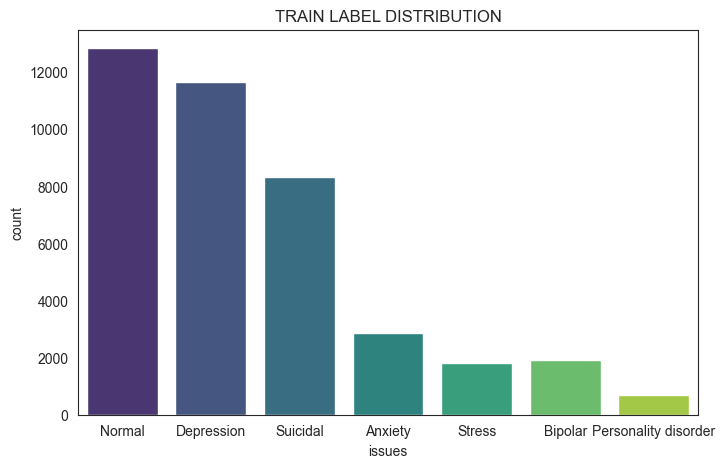

In [21]:
plt.figure(figsize=(8,5))
plt.title('TRAIN LABEL DISTRIBUTION')
sns.set_style('white')
sns.countplot(x='issues',data=df,palette='viridis',order=['Normal','Depression','Suicidal','Anxiety','Stress','Bipolar','Personality disorder'])

<Axes: title={'center': 'TEST LABEL DISTRIBUTION'}, xlabel='issues', ylabel='count'>

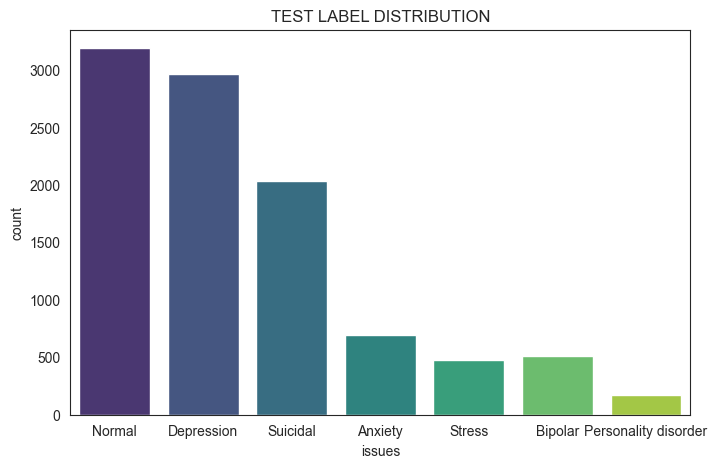

In [22]:
df_test = dataset['test'][:]
plt.figure(figsize=(8,5))
plt.title('TEST LABEL DISTRIBUTION')
sns.set_style('white')
sns.countplot(x='issues',data=df_test,palette='viridis',order=['Normal','Depression','Suicidal','Anxiety','Stress','Bipolar','Personality disorder'])

In [23]:
df['wrd_len'] = df['text'].str.split().apply(len)

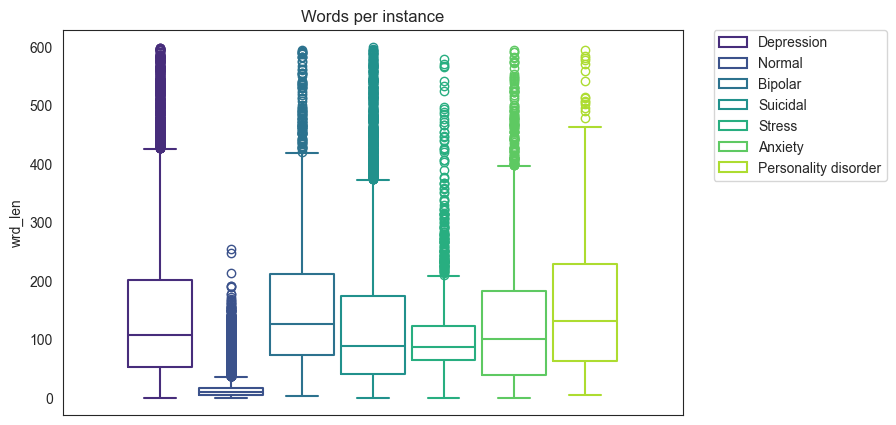

In [24]:
plt.figure(figsize=(8,5))
plt.title('Words per instance')
sns.boxplot(y='wrd_len',data=df,hue='issues',palette='viridis',gap=0.1,fill=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Reset back to oringal format

In [25]:
dataset.reset_format()

In [26]:
#loading tokenizer
from transformers import AutoTokenizer
model_path = 'FacebookAI/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [27]:
text = "this is pretrained tokenizer of RoBERTa model"
out = tokenizer(text)

In [28]:
tokenizer.convert_ids_to_tokens(out.input_ids)

['<s>',
 'this',
 'Ġis',
 'Ġpret',
 'rained',
 'Ġtoken',
 'izer',
 'Ġof',
 'ĠRo',
 'BER',
 'Ta',
 'Ġmodel',
 '</s>']

In [29]:
#tokenize the dataset
def apply_tokenizer(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [30]:
dataset_encoded = dataset.map(apply_tokenizer,batched=True,batch_size=None)

Map:   0%|          | 0/40148 [00:00<?, ? examples/s]

Map:   0%|          | 0/10038 [00:00<?, ? examples/s]

In [31]:
dataset_encoded.set_format("pt",columns=['input_ids','attention_mask','label'])

### load model

In [35]:
from transformers import AutoModelForSequenceClassification
num_labels = 7
model = (AutoModelForSequenceClassification.from_pretrained(model_path,num_labels=num_labels).to(device))

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    lables = pred.label_ids
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'f1':f1,'acc':acc}

### training parameters

In [38]:
from transformers import TrainingArguments
model_name = 'Mental-Health-RoBERTa'
batch_size = 4
learning_rate = 2e-5
num_train_epochs = 2
weight_decay = 0.01
logging_steps = len(dataset_encoded['train'])//batch_size
training_args = TrainingArguments(output_dir=model_name,
                                 per_device_eval_batch_size=batch_size,
                                 per_device_train_batch_size=batch_size,
                                 learning_rate=learning_rate,
                                 num_train_epochs=num_train_epochs,
                                 weight_decay=weight_decay,
                                 logging_steps=logging_steps,
                                 log_level="error",
                                 eval_strategy="epoch",
                                 disable_tqdm=False,
                                 push_to_hub=True)

In [41]:
from huggingface_hub import notebook_login
notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
from transformers import Trainer
trainer = Trainer(model=model,
                 compute_metrics=compute_metrics,
                 args =training_args,
                 train_dataset=dataset_encoded['train'],
                 eval_dataset=dataset_encoded['test'],
                 tokenizer = tokenizer)

In [43]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 